# **Heart Disease Classification With a K-Nearest Neighbors Algorithm**
**Authors:** Andy Hu, Sharon Tu, Dylan Zhang, Renz Tingson

# 1) Introduction
When will we find the cure to cancer? What is the newest cutting edge medical technology? Medicine is on the forefront of innovation and advancement, with people pouring in extensive resources for research purposes and progression. In particular, heart disease is the second leading cause of death among Canadians, with roughly 1 in 12 adults recieving a diagnosis within their lifetime. Heart disease is a broad term that encompasses a variety of conditions affecting the cardiovasular system, comprised of the heart and blood vessels. The most common of these conditions include coronary heart disease, angina, heart attacks, heart failure, arrhythmias, and stroke. As such, it is crucial to be able to detect and diagnose heart disease early in order to prevent long-term deficits, or potentially even death. Our research aims to find ways in which we can accomplish this in way that is accessible to everyone.

## Research Question
How well can we classify if a patient has a heart disease based on factors that can be more easily diagnoased at home, such as their age and maximum heart rate achieved? For our purposes, presence of a heart disease is indicated by greater than 50% diameter narrowing of blood vessels.

## Significance
Such findings could have a great impact in reducing the amount of fatal heart disease problems. If someone can easily use our model to reliably predict if they are at risk of heart disease, they will have the ability go seek further medical attention from a specialist or doctor before it gets out of hand and terminal. The predictors we use are all easily monitorable factors that do not require much external equipment to measure, so it is readily accessible by everyone to self diagnose. 

## Dataset
We will be using the Cleveland dataset for our research, which contains 14 distinct characteristics about each patient in the data. We will be focusing primarily on numerical predictors rather than categorical labels, with our classification predicting a patient's condition of having a heart disease. The Cleveland dataset classifies patient's heart disease on a scale from zero to four, where zero means that there is no presence of a heart disease, whereas the labels one to four indicate the severity of the heart disease in increasing order. For our purposes, we will treat the labels from one to four all as one, indicating the presence of a heart disease.

# 2) Methods & Results
To begin our research, we first explore the dataset to discover what factors constitute the most significant impact in determining whether someone has a heart disease or not. After finding these predictor variables, we utilize the Cleveland dataset and split it into a train/test split, and further perform cross validation on our training data to tune for an optimal `k` value to use in a K-Nearest Neighbor algorithm for classification. Upon finding an optimal value for the number of neighbors to use, we will retrain our model once again with the tuned `k` value and compare its accuracy against the testing data, which includes the classification type of each of the patients that our model will try and predict.

In [1]:
# Load in all preliminary packages needed for analysis
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
## Make a vector of column names to use for the dataset
vec_names <- c( "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num" )

# Load the dataset into R, and clean/wrangle the data into a tidy format
heart_data <- read_csv("data/cleveland_heart.txt", col_names = vec_names) |>
    mutate(across(sex:cp, as_factor)) |>                                  # Turn all categorical values into factors since they are
    mutate(across(fbs:restecg, as_factor)) |>                             # defaulted as chars when loaded
    mutate(exang = as_factor(exang)) |>
    mutate(across(slope:num, as_factor)) |>
    mutate(num = replace(num, num == 2 | num == 3 | num == 4, 1))         # This column labels patients on a scale of 0 to 4, where 0 is heart disease,
                                                                          # and 1-4 describe the severity of the heart disease. We turn these severity
                                                                          # cases into a value of 1, indicating presence of heart disease.
head(heart_data)
# write_csv(heart_data, "data/cleveland_data.csv")         # writes a tidy version of the original text file into the working directory for future reference

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


### Exploratory Analysis
We first use the entire dataset to gain meaningful insights from it. Let us first understand the column parameters a bit better through a table describing their labels.

In [3]:
data_labels <- tibble(label = c("age", "sex", "cp", "trestbps", "chol",
                                "fbs", "restecg", "thalach", "exang", "oldpeak",
                                "slope", "ca", "thal", "num"), 
                      description = c("age in years", "male(1) or female(0)",
                                      "Chest Pain Type (4 categories)",
                                      "Resting Blood Pressure (mmHg)",
                                      "Serum Cholesterol (mg/dl)",
                                      "Fasting Blood Sugar > 120mg/dl (true or false)\n",
                                      "Resting electrocardiographic results \n (0 as normal, else abnormality)",
                                      "Maximum Heart Rate Achieved (bpm)",
                                      "Exercise-induced angina (true or false)",
                                      "ST depression from exercise",
                                      "Slope of Peak Exercise ST Segment",
                                      "Number of Major Vessels (0-3)",
                                      "State of Heart Illness",
                                      "Status (true or false)"))

data_labels

label,description
<chr>,<chr>
age,age in years
sex,male(1) or female(0)
cp,Chest Pain Type (4 categories)
trestbps,Resting Blood Pressure (mmHg)
chol,Serum Cholesterol (mg/dl)
fbs,Fasting Blood Sugar > 120mg/dl (true or false)
restecg,"Resting electrocardiographic results (0 as normal, else abnormality)"
thalach,Maximum Heart Rate Achieved (bpm)
exang,Exercise-induced angina (true or false)


Our research aims to identify predictors that can be easily tracked at home without the need to go to a hospital to specifically test for heart disease, so that individuals can be proactive about their health and wellbeing at all times and have the ability to discover the potential presence of a heart disease based on easily monitorable predictors. As such, we specifically pick out predictors that everyone can monitor: Age, Sex, Serum Cholesterol, Resting Blood Pressure, Fasting Blood Sugar Level, Maximum Heart Rate Achieved, and Exercise-induced angina. 

In [4]:
heart_filtered <- heart_data |>
    select(age, sex, chol, trestbps, fbs, thalach, exang)

head(heart_filtered)

age,sex,chol,trestbps,fbs,thalach,exang
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>
63,1,233,145,1,150,0
67,1,286,160,0,108,1
67,1,229,120,0,129,1
37,1,250,130,0,187,0
41,0,204,130,0,172,0
56,1,236,120,0,178,0


We decide that for our research, we will only be considering the numerical labels for analysis to determine relationships between predictor variables through simple visualizations of scatter plots and finding correlations between our variables. Numerical columns include age, resting blood pressure, cholesterol levels, and maximum heart rate. 

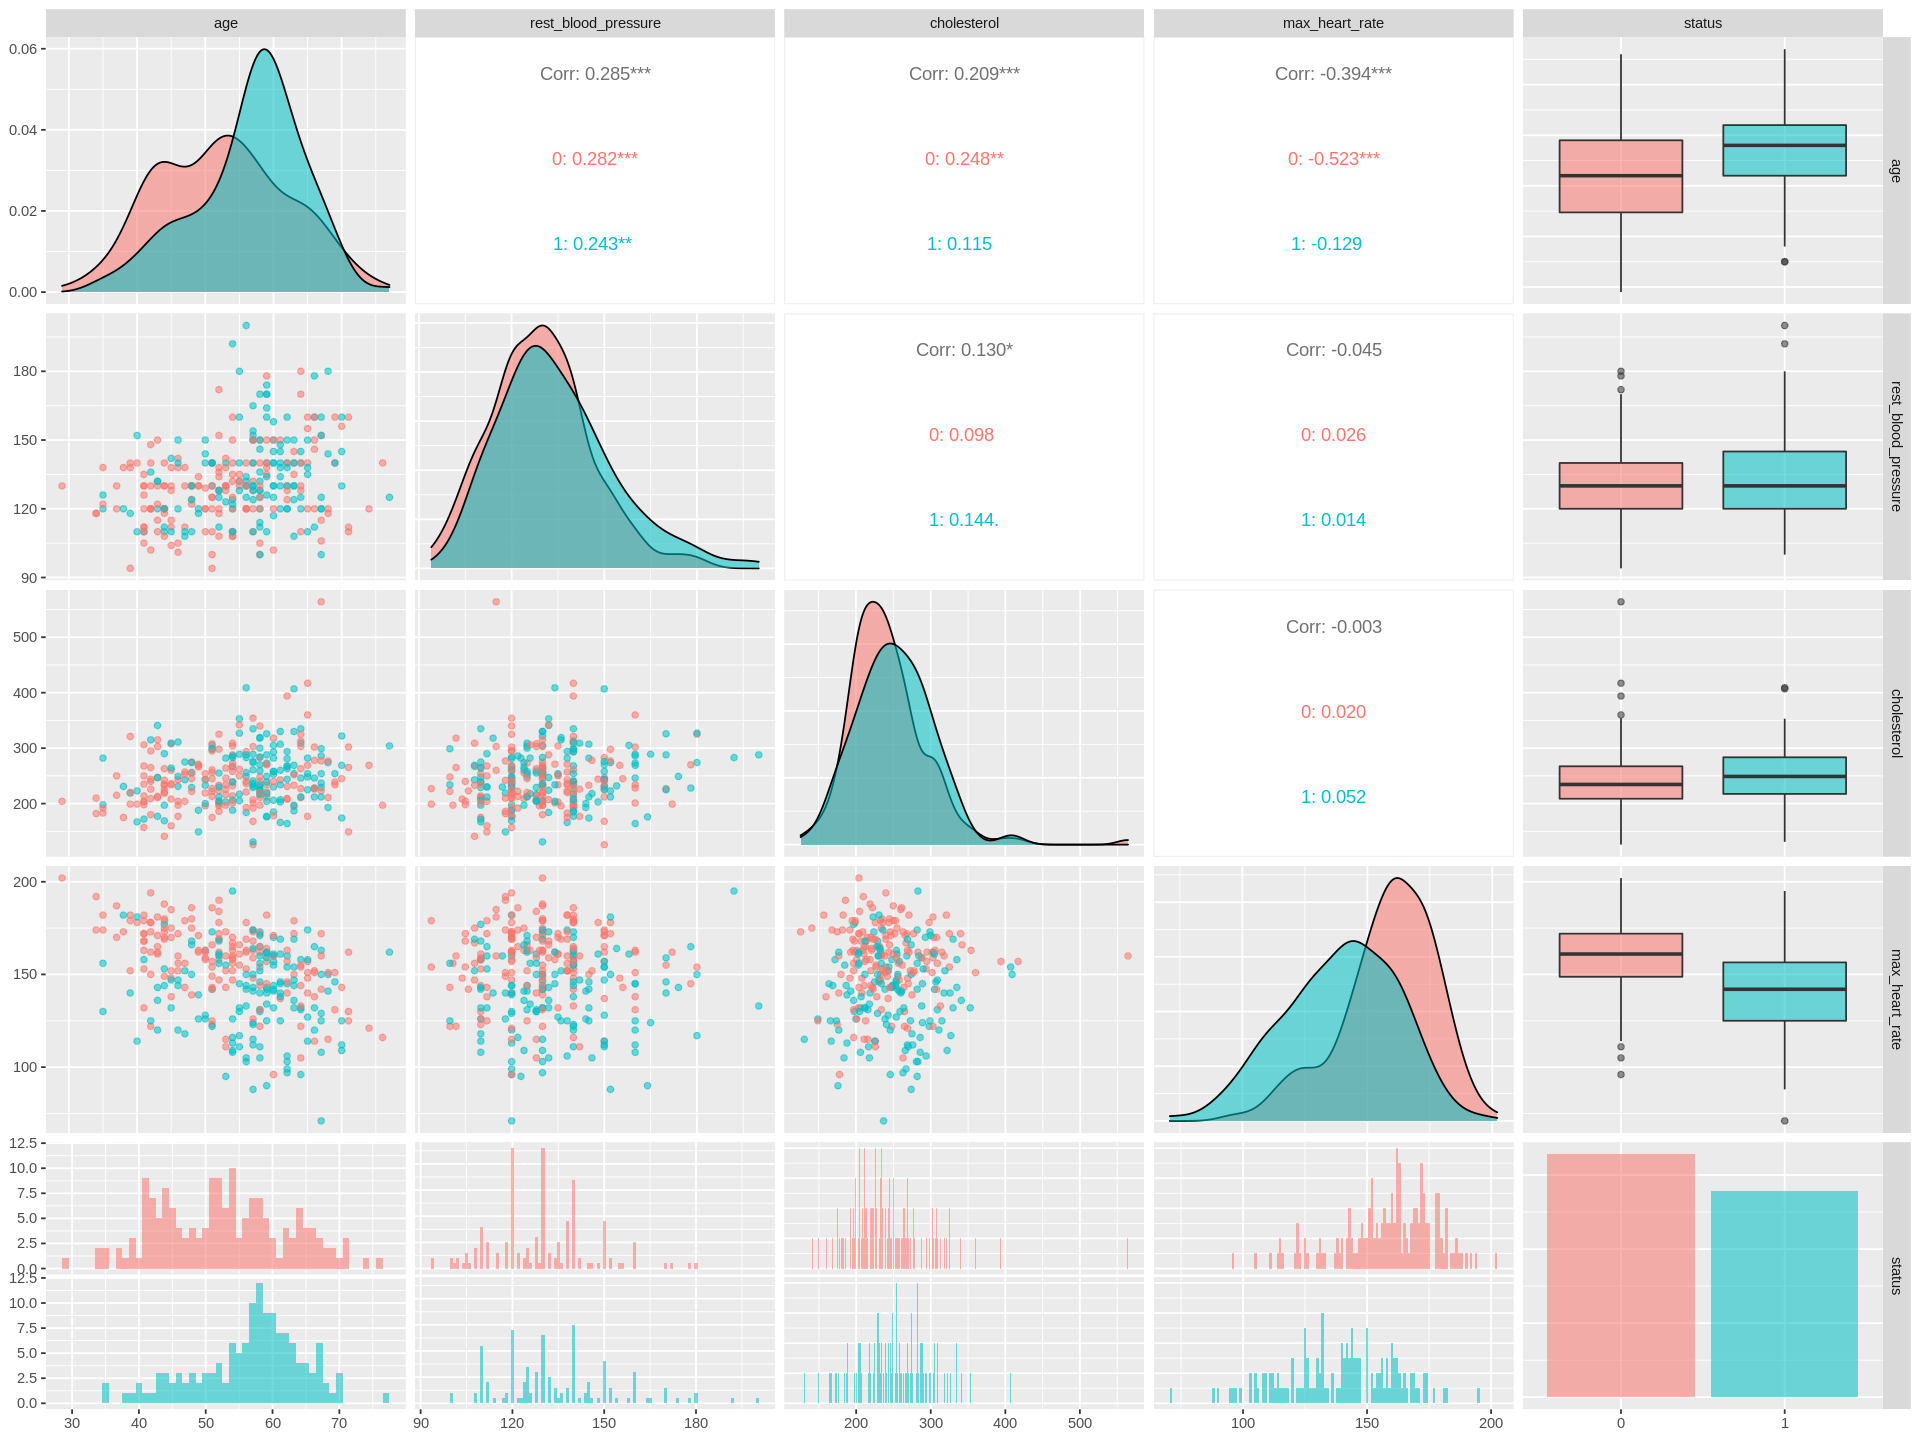

In [5]:
options(repr.plot.width = 16, repr.plot.height = 12)

# Select only numerical columns as well as response variable of num, indicating the status of the patient (has heart disease or not)
heart_filtered <- heart_data |>
    select(age, trestbps, chol, thalach, num)

# Create more interpretable column names
colnames(heart_filtered) <- c("age", "rest_blood_pressure", "cholesterol", "max_heart_rate", "status")

# Plot simple visualization to explore dataset
distribution_plot <- ggpairs(data = heart_filtered,
                            aes(colour = status, alpha = 0.6),
                            lower=list(combo=wrap("facethist",binwidth=1)))
distribution_plot

Based on the given plot above, we can easily explore the dataset from a bird's eye view. We quickly notice that the dataset contains more patients without heart disease compared to with heart disease. We also notice that some predictors combined together have little accuracy in determining whether a patient has heart disease or not, such as the scatter plot resulting from maximum heart rate and cholesterol levels, or resting heart rate and maximum heart rate together. We take note of the different Pearson correlations shared by certain factors, which classifies the strength and direction of the relationship between both variables. We quickly notice that the highest Pearson correlation given the data occurs while plotting maximum heart rate and age together, and that they have a negative relationship. We also see that compared to the other scatter plots, the distinction between those with heart disease and without is most prominent in this plot, indicating the potential for a relatively high accuracy model that can be trained from using those two predictors. 

As a matter of fact, age and maximum heart rate have a natural relationship with one another. According to the Centers for Disease Control and Prevention, an individual's maximum heart rate should be 220 subtracted by your age, showing a strong correlation extractable from age and maximum heart rate. Furthermore, age itself plays a massive role in overall health of the heart and therefore plays a significant role in predicting heart disease. With aging, the heart's ability to pump blood to the rest of the body worsens, as a result of simply overworking and the buildup of fat deposits and increased stiffness. 

As such, we will choose to use age and maximum heart rate achieved for the rest of this paper.

In [6]:
# Compress the data so that it only contains the predictors we care about (age, maximum heart rate) and response variable of status.
heart <- heart_filtered |>
    select(age, max_heart_rate, status)
head(heart)

age,max_heart_rate,status
<dbl>,<dbl>,<fct>
63,150,0
67,108,1
67,129,1
37,187,0
41,172,0
56,178,0


Through the use of simple tables and calculations, we can understand the relationship between our chosen predictors better and overall dataset to look for any outliers or imbalances present within the dataset.

In [7]:
# Calculate the number of NA values present
na <- sum(is.na(heart))
na

[1] 0

With a simple calculation, we discover that there are no NA values in our dataset, so it is unnecessary to worry about them nor remove any. 

In [8]:
## Summarize the data in at least one table. Eg. Report number of observations in each class,
## means of predictor variables you plan to use,

num_obs <- heart |>
    group_by(status) |>
    summarize(count = n())
num_obs

status,count
<fct>,<int>
0,164
1,139


From above, a status of 0 indicates no heart disease, while a value of 1 indicates the presence of a heart disease. The data is relatively balanced between patients with and without heart disease, although there is a slight bias towards those without heart disease. Up sampling of those with heart disease could be possible, but not necessary.

In [9]:
means <- heart |>
    group_by(status) |>
    summarize(across(age:max_heart_rate, mean))
means

status,age,max_heart_rate
<fct>,<dbl>,<dbl>
0,52.58537,158.378
1,56.62590,139.259


Based on the table and the graphs above, we can see that those with higher age and lower maximum heart rate tend to have a heart disease, while those with lower age and higher maximum heart rate tend to not have heart disease. From the data, we see that the mean average for age was around 57 for those with heart disease compared to 53 to those without heart disease, and that the maximum heart rate for those with heart disease was around 140bpm, and around 158 for those without. Let us zoom in on the graph corresponding to the relationship between age and maximum heart rate now. 

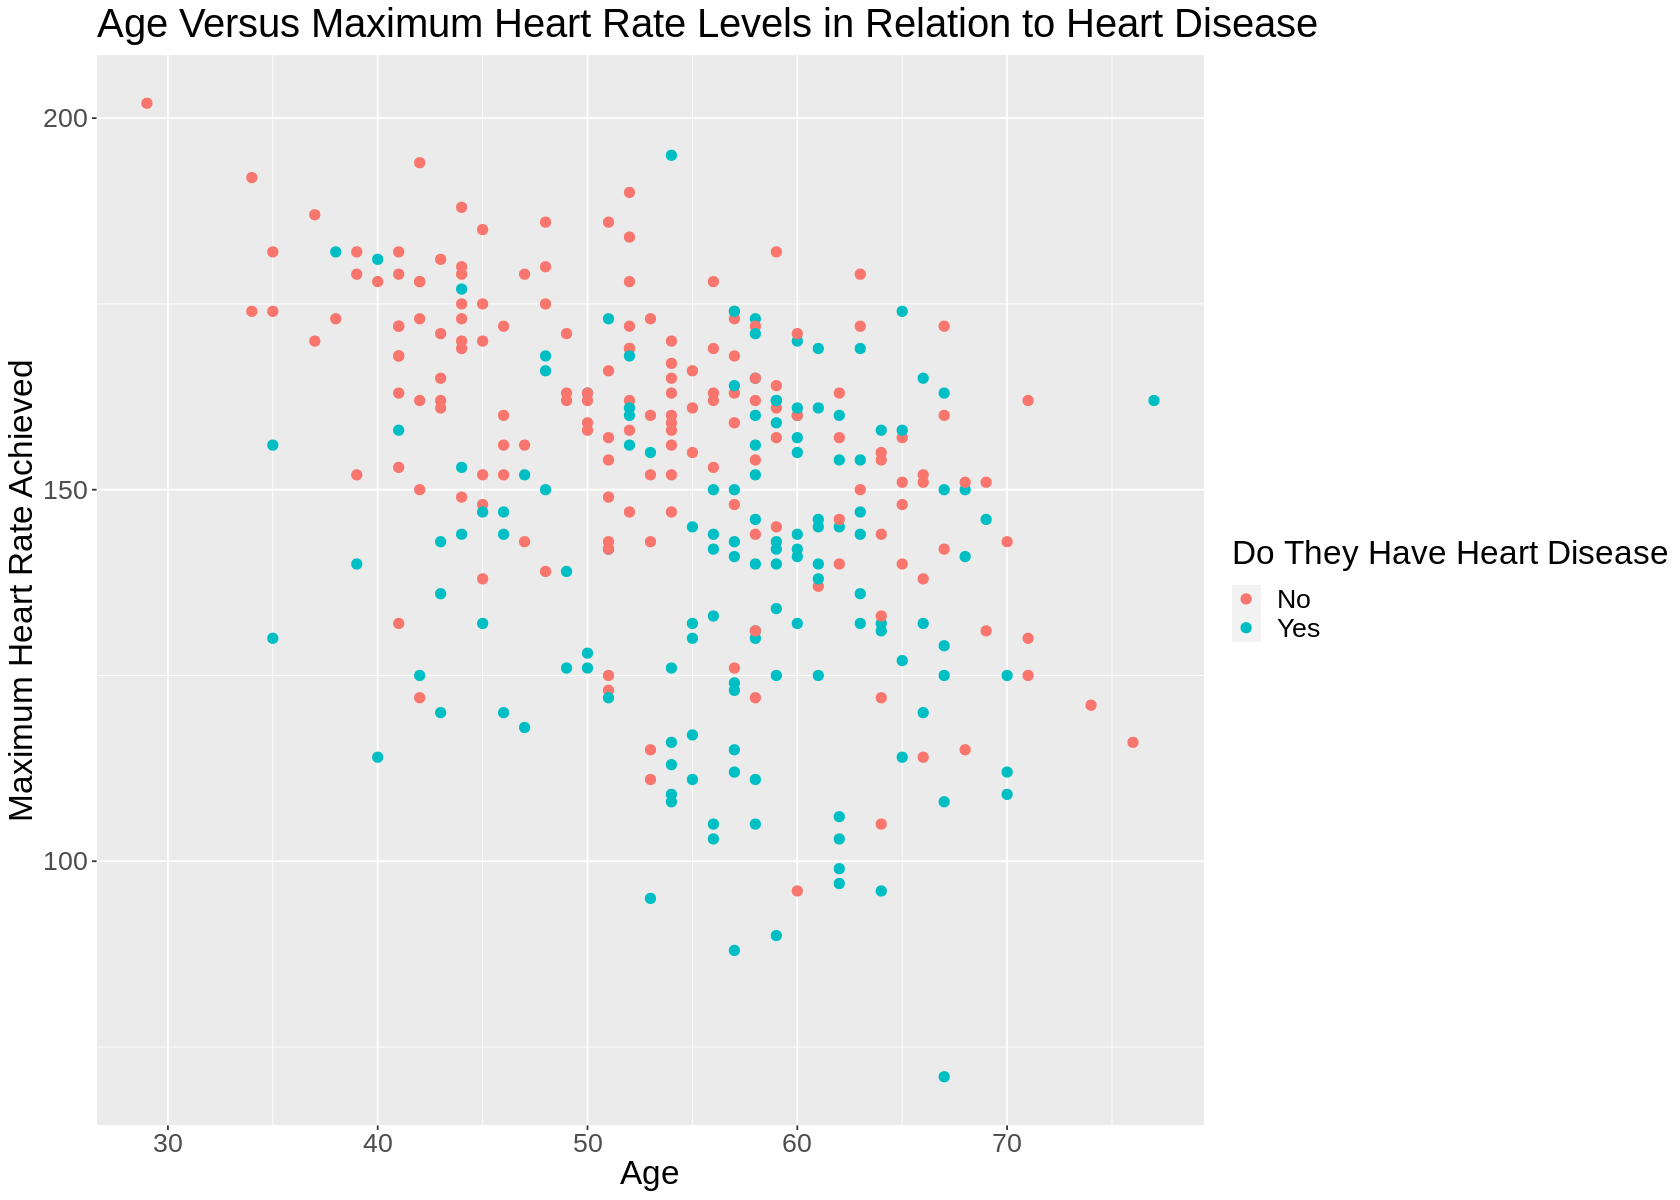

In [11]:
options(repr.plot.width = 14, repr.plot.height = 10)

# age_hist <- heart_training |>
#     ggplot(aes(x = age, fill = status)) +
#     geom_histogram(size = 2.5, position = "dodge") +
#     xlab("Age") +
#     ylab("Frequency") +
#     labs(fill = "Do They Have Heart Disease") +
#     ggtitle("Age Distribution in Relation to Heart Disease") +
#     scale_fill_discrete(labels = c("No", "Yes")) +
#     theme(text = element_text(size = 20))
# age_hist

# max_heart_rate_plot <- heart_training |>
#     ggplot(aes(x = max_heart_rate, fill = status)) +
#     geom_histogram(size = 2.5, position = "dodge") +
#     labs(x = "Maximum Heart Rate Achieved", y = "Frequency") +
#     labs(fill = "Do They Have Heart Disease") +
#     ggtitle("Maximum Heart Rate Distribution in Relation to Heart Disease") +
#     scale_fill_discrete(labels = c("No", "Yes")) +
#     theme(text = element_text(size = 20))
# max_heart_rate_plot

heart_scatter <- heart |>
    ggplot(aes(x = age, y = max_heart_rate, color = status)) +
    geom_point(size = 2.5) +
    xlab("Age") +
    ylab("Maximum Heart Rate Achieved") +
    labs(color = "Do They Have Heart Disease") +
    ggtitle("Age Versus Maximum Heart Rate Levels in Relation to Heart Disease") +
    scale_color_discrete(labels = c("No", "Yes")) +
    theme(text = element_text(size = 20))
heart_scatter


Just like our table above showed, those with higher age and lower maximum heart rate achieved seem to have a higher likelihood of having a heart disease compared to those with lower age and higher maximum heart rate achieved, and we also take note of the negative relationship between both variables.

In [12]:
set.seed(1500)

# Splits our entire dataset into 75% training, and 25% testing
heart_split <- initial_split(heart, prop = 0.75, strata = status)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

In [73]:
## Recipe
set.seed(1500)

# - Make a recipe with a formula predicting status based on the predictors of
#   age and maximum heart rate achieved, using training data.
# - Standardize the data to ensure the scales are properly set for use 
#   of straight line distance in the K-nearest neighbors algorithm
heart_recipe <- recipe(status ~ ., data = heart_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Create the model specification using Euclidean straight line distance
# and tune the number of neighbors
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# create the folds for 5-fold cross-validation
heart_vfold <- vfold_cv(heart_training, v = 5, strata = status) 

# create a table of neighbor values to test (tuning the k value)
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))

# compute statistics at different k values
heart_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    tune_grid(resamples = heart_vfold, grid = gridvals) |>
    collect_metrics()

# discover the accuracy of the model at different values of k
accuracies <- heart_results |>
    filter(.metric == "accuracy")
accuracies

! Fold1: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5944181,5,0.02761267,Preprocessor1_Model01
6,accuracy,multiclass,0.6518138,5,0.02819976,Preprocessor1_Model02
11,accuracy,multiclass,0.6828415,5,0.02429520,Preprocessor1_Model03
16,accuracy,multiclass,0.6780018,5,0.03072141,Preprocessor1_Model04
21,accuracy,multiclass,0.6779051,5,0.03792100,Preprocessor1_Model05
26,accuracy,multiclass,0.6780018,5,0.03072141,Preprocessor1_Model06
31,accuracy,multiclass,0.6867896,5,0.03062973,Preprocessor1_Model07
36,accuracy,multiclass,0.6867852,5,0.03089944,Preprocessor1_Model08
41,accuracy,multiclass,0.6867896,5,0.02366662,Preprocessor1_Model09


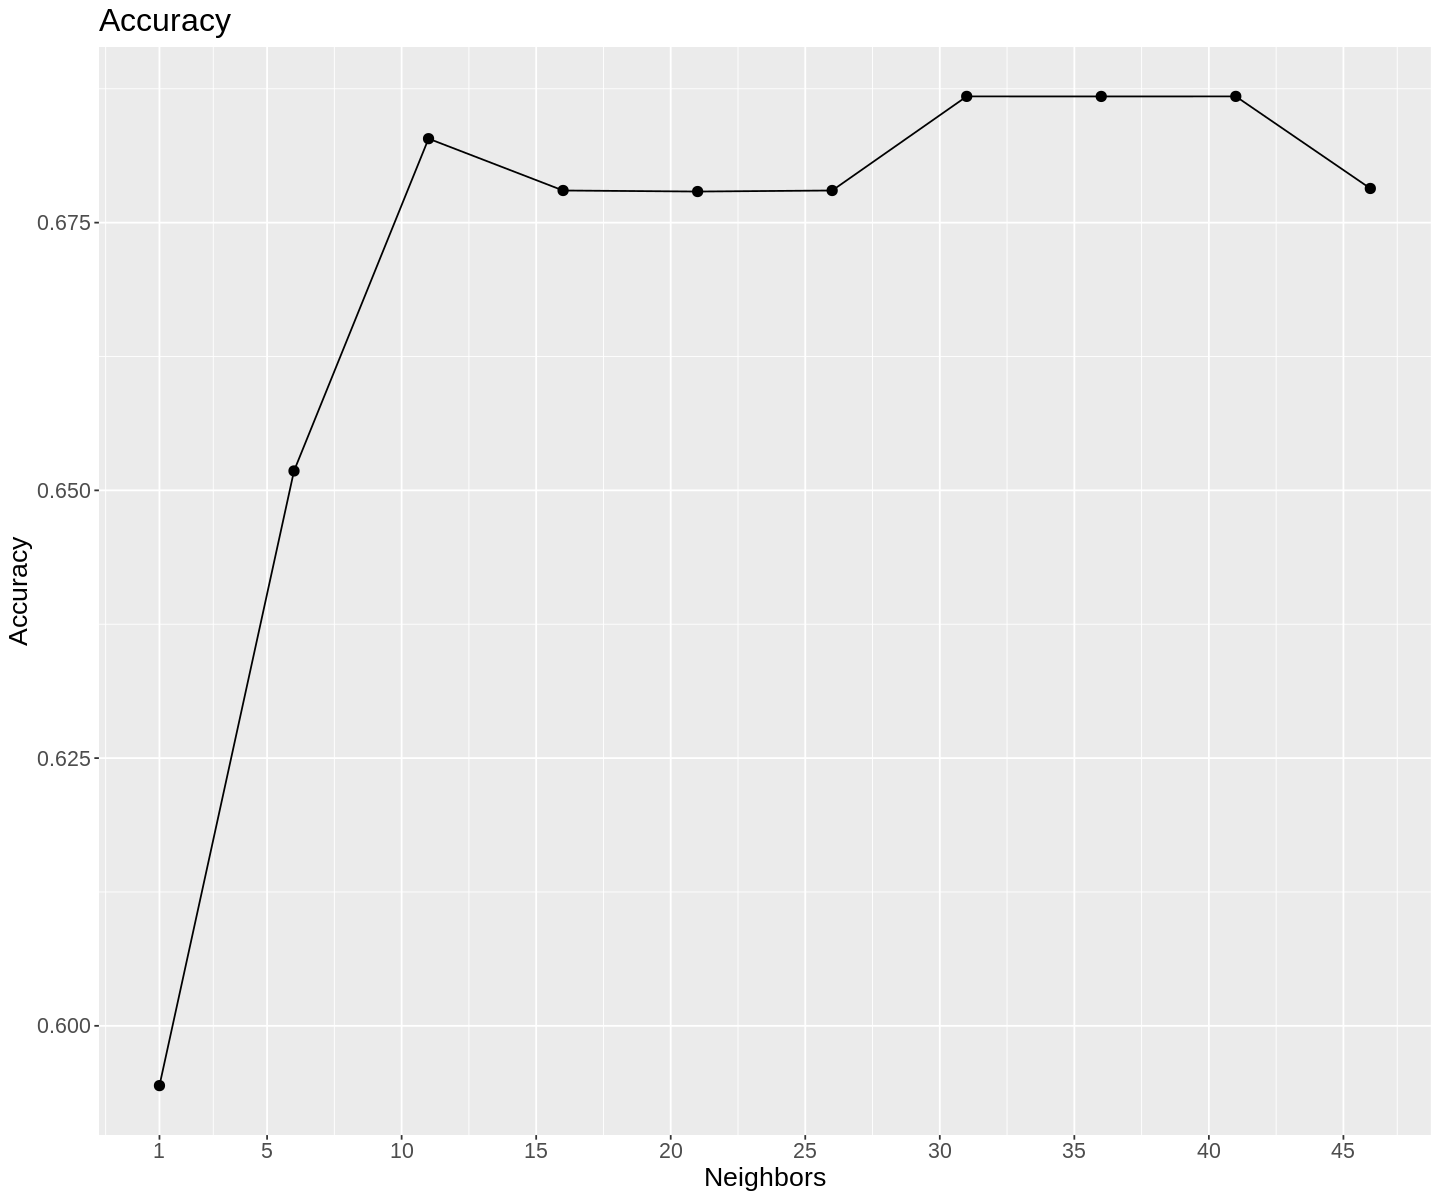

In [74]:
options(repr.plot.width = 12, repr.plot.height = 10)

# plot of the accuracies at different values of k
accuracy_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point(size = 2.5) +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy", title = "Accuracy") + 
    scale_x_continuous(breaks = c(1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50)) +
    theme(text = element_text(size = 16))

accuracy_plot

The graph above represents the accuracy of the model at different `k` values, or number of neighbors. We see that the graph reaches a its first peak at around 10 neighbors, and then fluctuates about that point for a while. Based on this, we can choose a `k` value of 15 since it seems like increasing the neighbors from that point on does not make a significant difference in the accuracy of the model, and these accuracies themselves are estimates in the first place. We also know that as the number of neighbors increases to an absurd amount, such as 100, the accuracy would decrease due to underfitting to the extreme. We choose the value of `k` to be a bit above the first peak at 10 to avoid the possibility of overfitting. 

In [81]:
# Using our analyzed best k value of 8 to retrain the model
heart_optimized <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_optimized) |>
    fit(heart_training) 

# use our retrained model with the best k value to predict values on the training set
predictions <- predict(heart_fit, heart_testing) |>
    bind_cols(heart_testing)

# get the statistics of our model's accuracy
results <- predictions |>
    metrics(truth = status, estimate = .pred_class) |>
    filter(.metric == "accuracy")

results

# visualize the model predictions in a matrix
predictions |>
    conf_mat(truth = status, estimate = .pred_class)


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7631579


          Truth
Prediction  0  1  2  3  4
         0 33 10  0  0  0
         1  8 25  0  0  0
         2  0  0  0  0  0
         3  0  0  0  0  0
         4  0  0  0  0  0

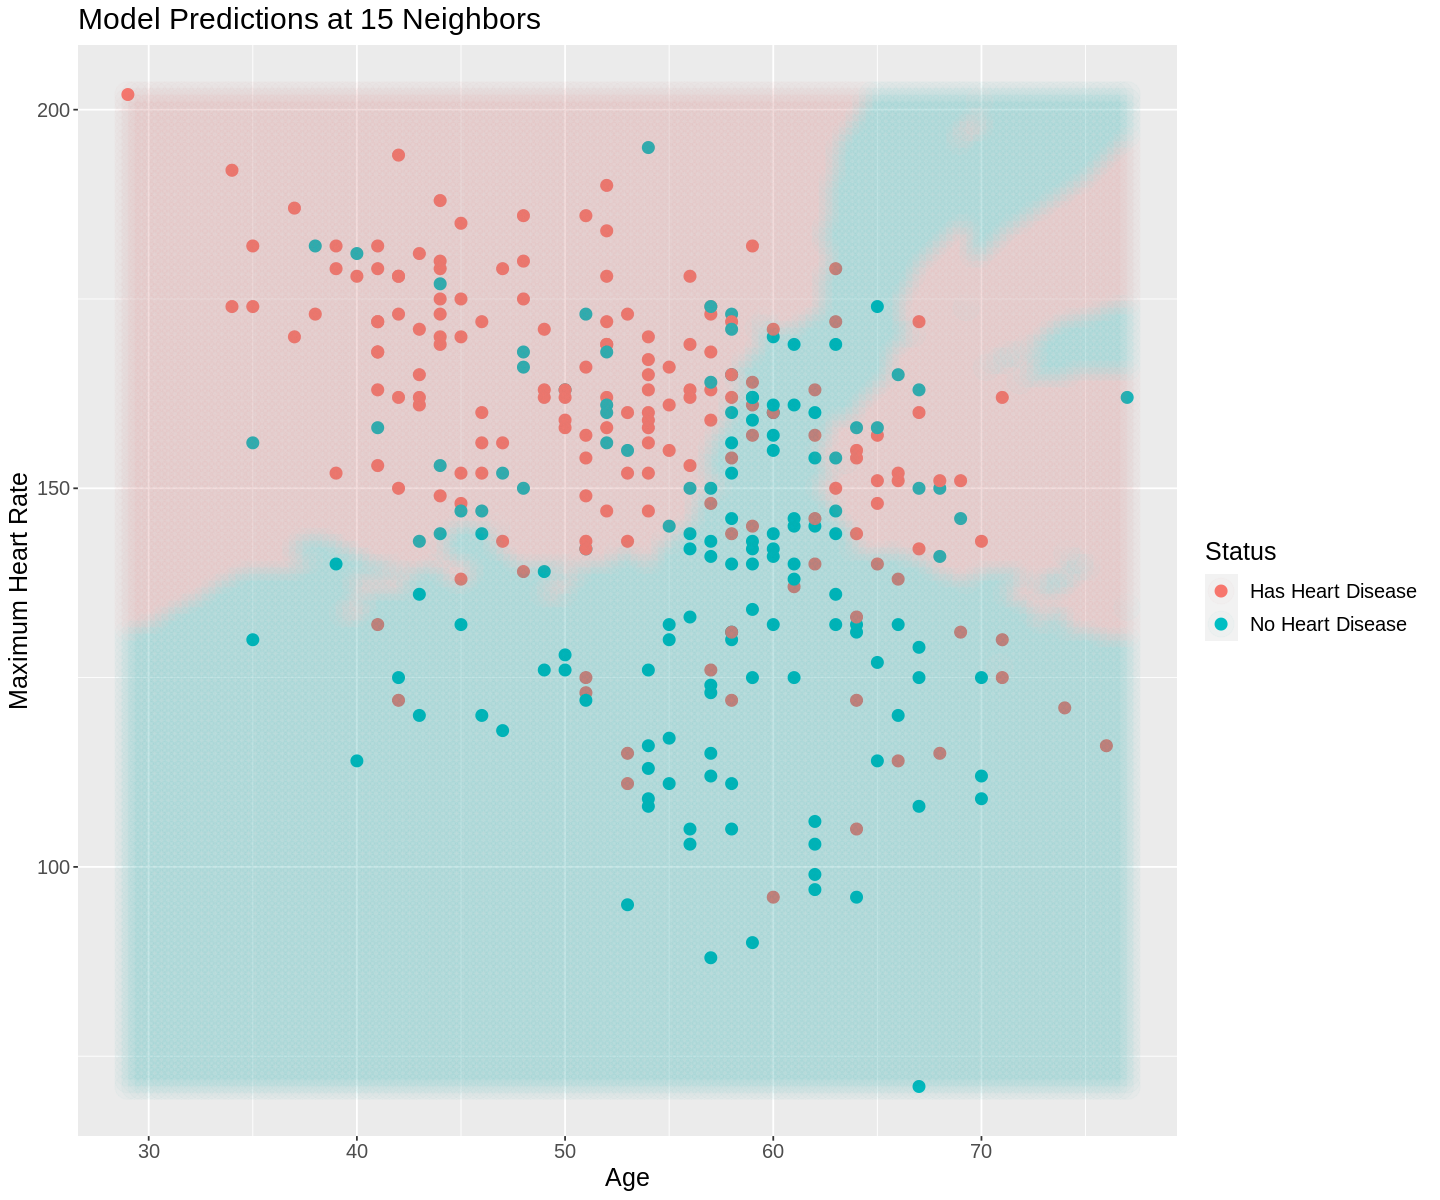

In [82]:
# create the grid of area/smoothness vals, and arrange in a data frame
age_grid <- seq(min(heart$age), 
                max(heart$age), 
                length.out = 150)
hr_grid <- seq(min(heart$max_heart_rate), 
                max(heart$max_heart_rate), 
                length.out = 150)
asgrid <- as_tibble(expand.grid(age = age_grid, 
                                max_heart_rate = hr_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(heart_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(Status = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = heart, 
             mapping = aes(x = age, 
                           y = max_heart_rate, 
                           color = status), 
             size = 3) +
  geom_point(data = prediction_table, 
             mapping = aes(x = age, 
                           y = max_heart_rate, 
                           color = Status), 
             alpha = 0.02, 
             size = 7) +
  labs(color = "Status", 
       x = "Age", 
       y = "Maximum Heart Rate",
       title = "Model Predictions at 15 Neighbors") +
  scale_color_discrete(labels = c("Has Heart Disease", "No Heart Disease")) +
  theme(text = element_text(size = 15))

wkflw_plot


### Add information on overfit/underfit for this graph

# 3) Discussion

## Summary
bruh


## Future Questions
While finding a model to predict whether or not someone has a heart disease is great, there are still many restrictions and limitations involved with our research, which raises the awareness to further questions. For example, can our model become a mainsteram way for people to reliably test if they have a heart disease and seek more medical attention? Also, to ensure maximum accuracy of our model, we may consider adding other predictors that have a larger impact on the effects on heart disease, and potentially revise our current model to support these additions and possibly remove some less significant predictors. We also recognize the limitations of employing a KNN algorithm for classification, so other variations could be considered. 

# 4) References
- https://archive.ics.uci.edu/dataset/45/heart+disease
- https://medlineplus.gov/ency/article/004006.htm
- https://www.nia.nih.gov/health/heart-health-and-aging
